In [7]:

import warnings

import pandas as pd
import torch
from torch import device, cuda, autocast
from torch.cuda.amp import GradScaler
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import flyvision
from flyvision.utils.activity_utils import LayerActivity
from flyvision_ans import DECODING_CELLS
import wandb
from conv_models import DecodingImagesCNN
from from_retina_to_connectome_utils import layer_activations_to_decoding_images, predictions_and_corrects_from_model_results, update_results_df, update_running_loss
from from_video_to_training_batched_funcs import get_files_from_directory, select_random_videos, paths_to_labels, load_custom_sequences
from utils import plot_weber_fraction
from logs_to_wandb import log_running_stats_to_wandb, log_validation_stats_to_wandb


warnings.filterwarnings(
    'ignore',
    message='invalid value encountered in cast',
    category=RuntimeWarning,
    module='wandb.sdk.data_types.image'
)

device_type = "cuda" if cuda.is_available() else "cpu"
DEVICE = device(device_type)
torch.manual_seed(42)
batch_size = 64
last_good_frame = 2

TRAINING_DATA_DIR = "videos/easy_videos"
TESTING_DATA_DIR = "videos/easyval_videos"

debugging = False
debug_length = 20
wandb_ = True
wandb_images_every = 10

num_epochs = 4

channel_sizes = [16, 32, 64]
mult_size = 1
channel_sizes = [int(a * mult_size) for a in channel_sizes]
dropout = .5
lr = .01
weight_decay = 1e-4

model_config = {
    "debugging": debugging,
    "num_epochs": num_epochs,
    "channel_sizes": channel_sizes,
    "dropout": dropout,
    "lr": lr,
    "weight_decay": weight_decay
}

In [8]:
network_view = flyvision.NetworkView(flyvision.results_dir / "opticflow/000/0000")
network = network_view.init_network(chkpt="best_chkpt")
dt = 1 / 100
extent, kernel_size = 15, 13
receptors = flyvision.rendering.BoxEye(extent=extent, kernel_size=kernel_size)

all_videos = get_files_from_directory(TRAINING_DATA_DIR)
all_validation_videos = get_files_from_directory(TESTING_DATA_DIR)

In [9]:
model = DecodingImagesCNN(
    out_channels_1 = channel_sizes[0],
    out_channels_2 = channel_sizes[1],
    out_channels_3 = channel_sizes[2],
    dropout = dropout
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scaler = GradScaler()

# Initialize the loss function
criterion = BCEWithLogitsLoss()

In [10]:
model.train()

iterations = debug_length if debugging else len(all_videos) // batch_size
# Start wandb run
if wandb_:
    wandb.init(project='la_classification', config=model_config)


results = pd.DataFrame(columns=["Image", "Prediction", "True label", "Is correct"])

# Training loop
for epoch in range(num_epochs):
    already_selected = []
    running_loss = 0.0
    total_correct = 0
    total = 0
    for i in tqdm(range(iterations)):
        batch_files, already_selected = select_random_videos(
            all_videos, batch_size, already_selected
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = load_custom_sequences(batch_files)
        rendered_sequences = receptors(batch_sequences)
        
        layer_activations = []
        for rendered_sequence in rendered_sequences:
            # rendered sequences are in RGB; move it to 0-1 for better training
            rendered_sequence = torch.div(rendered_sequence, 255)
            # TODO: try to run this on cpu to parallelize it
            simulation = network.simulate(rendered_sequence[None], dt)
            layer_activations.append(
                LayerActivity(simulation, network.connectome, keepref=True)
            )
        
        decoding_images = layer_activations_to_decoding_images(layer_activations, last_good_frame, DECODING_CELLS)
        
        # Ensure the data is in tensor form and on the correct device
        labels_tensor = torch.tensor(labels, dtype=torch.float).to(DEVICE)
        batch_sequences_tensor = torch.tensor(decoding_images, dtype=torch.float).to(DEVICE)

        # Create the dataset and dataloader
        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs.to(DEVICE)
            batch_labels.to(DEVICE)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
    
            # Forward pass
            with autocast(device_type):
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), batch_labels)
                loss.backward()
                optimizer.step()
    
                # Calculate run parameters
                predictions, batch_labels_cpu, correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
                results = update_results_df(results, batch_files, predictions, batch_labels_cpu, correct)
                running_loss += update_running_loss(loss, inputs)
                total += batch_labels.shape[0]
                total_correct += correct.sum()
                
        # Log metrics to wandb
        if wandb_:
            log_running_stats_to_wandb(epoch, running_loss, total_correct, total, results)

    print(f'Epoch {epoch+1}, Loss: {running_loss / total}, Accuracy: {total_correct / total}')

100%|██████████| 262/262 [1:16:41<00:00, 17.56s/it]


Epoch 1, Loss: 0.632039011662243, Accuracy: 0.6268487595419847


100%|██████████| 262/262 [1:21:27<00:00, 18.65s/it]


Epoch 2, Loss: 0.5162786742430607, Accuracy: 0.7439169847328244


100%|██████████| 262/262 [1:26:29<00:00, 19.81s/it]


Epoch 3, Loss: 0.49223759850017895, Accuracy: 0.7625238549618321


100%|██████████| 262/262 [1:30:18<00:00, 20.68s/it]

Epoch 4, Loss: 0.4807354801028739, Accuracy: 0.7668177480916031


In [11]:
model.eval() 

total_correct = 0
total = 0
running_loss = 0.0

validation_results = pd.DataFrame(columns=["Image", "Prediction", "True label", "Is correct"])

with (torch.no_grad()):
    for i in tqdm(range(len(all_validation_videos) // batch_size)):
        batch_files, _ = select_random_videos(
            all_validation_videos, batch_size, already_selected=[]
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = load_custom_sequences(batch_files)
        rendered_sequences = receptors(batch_sequences)
        
        layer_activations = []
        for rendered_sequence in rendered_sequences:
            # rendered sequences are in RGB; move it to 0-1 for better training
            rendered_sequence = torch.div(rendered_sequence, 255)
            simulation = network.simulate(rendered_sequence[None], dt)
            layer_activations.append(
                LayerActivity(simulation, network.connectome, keepref=True)
            )
        
        decoding_images = layer_activations_to_decoding_images(layer_activations, last_good_frame, DECODING_CELLS)
        
        # Ensure the data is in tensor form and on the correct device
        labels_tensor = torch.tensor(labels, dtype=torch.float).to(DEVICE)
        batch_sequences_tensor = torch.tensor(decoding_images, dtype=torch.float).to(DEVICE)

        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs, batch_labels = inputs.to(DEVICE), batch_labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), batch_labels)

            predictions, batch_labels_cpu, correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
            validation_results = update_results_df(validation_results, batch_files, predictions, batch_labels_cpu, correct)
            running_loss += update_running_loss(loss, inputs)
            total += batch_labels_cpu.shape[0]
            total_correct += correct.sum().item()
            
            
print(f'Validation Loss: {running_loss / total}, '
      f'Validation Accuracy: {total_correct / total}')

100%|██████████| 61/61 [16:43<00:00, 16.45s/it]

Validation Loss: 2.5640169909743014, Validation Accuracy: 0.4930840163934426


accuracy,▁▁▂▂▂▃▃▄▄▄▆▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇██████████
epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
loss,██▇▇▇▆▆▆▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁
val_loss,▁
accuracy,0.76682
epoch,3
loss,0.48074
val_accuracy,0.49308
val_loss,2.56402


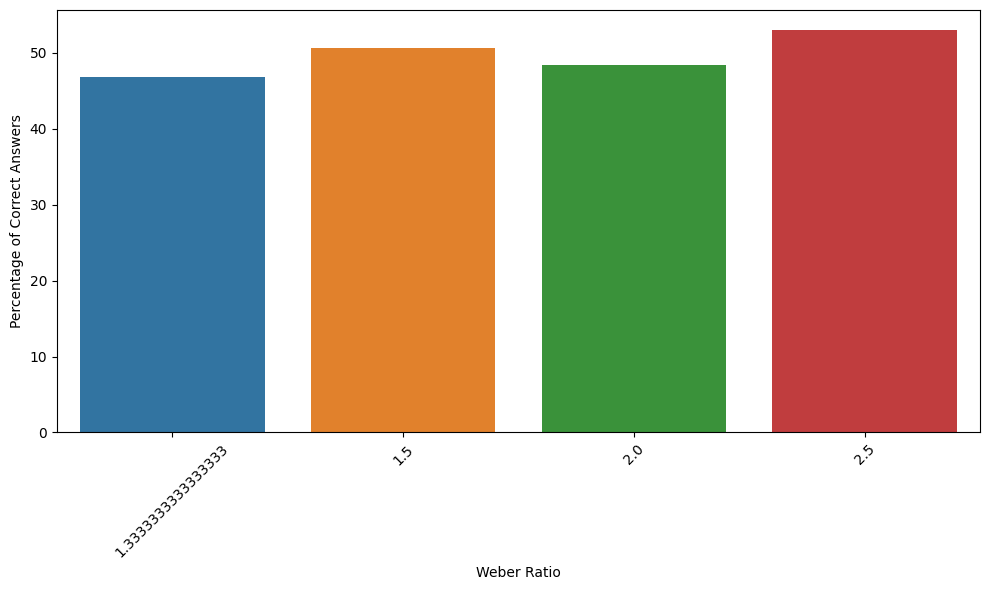

In [12]:
weber_plot = plot_weber_fraction(validation_results)

# Log validation metrics to wandb
if wandb_:
    log_validation_stats_to_wandb(running_loss, total_correct, total, validation_results, weber_plot)
    wandb.finish()

In [9]:
from pytorch_model_summary import summary

print(summary(DecodingImagesCNN(), torch.zeros((1, 34, 31, 31)), show_input=True))

---------------------------------------------------------------------------
          Layer (type)         Input Shape         Param #     Tr. Param #
              Conv2d-1     [1, 34, 31, 31]           4,912           4,912
         BatchNorm2d-2     [1, 16, 31, 31]              32              32
             Dropout-3     [1, 16, 15, 15]               0               0
              Conv2d-4     [1, 16, 15, 15]           4,640           4,640
         BatchNorm2d-5     [1, 32, 15, 15]              64              64
              Conv2d-6       [1, 32, 7, 7]          18,496          18,496
         BatchNorm2d-7       [1, 64, 7, 7]             128             128
   AdaptiveAvgPool2d-8       [1, 64, 3, 3]               0               0
              Linear-9             [1, 64]              65              65
Total params: 28,337
Trainable params: 28,337
Non-trainable params: 0
---------------------------------------------------------------------------
